### Construindo árvores de sobrevivência

In [1]:
import pandas as pd
from sksurv.tree import SurvivalTree
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sksurv.datasets import get_x_y
from sksurv.tree import SurvivalTree
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import brier_score, concordance_index_censored
import plot_survival_tree
from lifelines import KaplanMeierFitter
from itertools import combinations, chain, product

Funções:

In [2]:
transform_int = lambda x: 1 if x == 'Sim' else 0

In [3]:
transform_int_in_english = lambda x: 1 if x == 'Yes' else 0

In [4]:
def transform_in_dummies(df, categorical_cols):
    df_dummies = pd.get_dummies(df[categorical_cols], drop_first=True)
    dummies_cols = df_dummies.columns
    return list(dummies_cols), df_dummies

Lendo os dados:

In [5]:
df = pd.read_csv("/Users/vinicius.oliveira/Downloads/ICESPv1.csv")

In [6]:
df.shape

(793, 33)

Tratamentos iniciais:

In [6]:
df['insuf_cardiaca'] = df['insuf_cardiaca3e4'].apply(lambda x: 1 if x == 'I/II' else 0)

In [7]:
df['tipo_cirurgia'] = df['tipo_cirurgia'].apply(lambda x: 'Nao' if type(x) == float else x)

In [8]:
df['tipo_quimioterapia'] = df['tipo_quimioterapia'].apply(lambda x: 'Nao' if type(x) == float else x)

In [9]:
df['tipo_radioterapia'] = df['tipo_radioterapia'].apply(lambda x: 'Nao' if type(x) == float else x)

In [10]:
meanQV0 = np.mean(df['QV.0'])
df['QV.0'] = df['QV.0'].apply(lambda x: meanQV0 if np.isnan(x) else x)

In [11]:
df['event'] = df['delta'].astype(bool)

Lendo o dataset:

In [12]:
df.head()

,Unnamed: 0,idpac,idade,sexo,imc,imc_cat,insuf_renal,insuf_resp,cirrose,alcoolismo,...,hospit_antes_uti,QV.0,QV.0Cat,SAPS3_Pontos,SAPS3cat,tempo,delta,centro,insuf_cardiaca,event
0,1,001/0001,29.876712,F,16.135394,Underweight,Nao,Nao,Nao,Nao,...,0,0.725,0.6 to 0.8,46,"[38,54)",240,1,ICESP,1,True
1,2,001/0002,26.945205,M,26.122449,Overweight,Nao,Nao,Nao,Nao,...,1,0.088,<0.4,65,"[54,93]",731,0,ICESP,1,False
2,3,001/0003,76.364384,M,27.440599,Overweight,Nao,Nao,Nao,Nao,...,1,0.850,0.8 to 1.0,38,"[38,54)",730,0,ICESP,1,False
3,4,001/0004,71.676712,M,24.382716,Healthy weight,Nao,Nao,Nao,Nao,...,4,0.710,0.6 to 0.8,66,"[54,93]",7,1,ICESP,1,True
4,5,001/0005,25.783562,M,18.113754,Underweight,Nao,Nao,Nao,Nao,...,3,-0.181,<0.4,44,"[38,54)",201,1,ICESP,1,True


Definindo alguns conjuntos de covariáveis:

In [13]:
lstSimNao = ['insuf_renal', 
             'insuf_resp', 
             'cirrose', 
             'alcoolismo'
             #'cirurgia',
             #'quimioterapia',
             #'radioterapia'
            ]

lstYesNo = ['diabetesSN',
            'deliriumSN']

lstCategorical = ['sexo',
                  'tipoadm',
                  'site_primario',
                  'status_cancer',
                  'extensao_cancer',
                  'tipo_cirurgia',
                  'tipo_quimioterapia',
                  'tipo_radioterapia']

lstNum = ['insuf_cardiaca',
          'idade', 
          'imc',
          'QV.0',
          'SAPS3_Pontos',
          'capac_func_ecog',
          'hospit_antes_uti']

In [14]:
for col in lstSimNao:
    
    df[col] = df[col].apply(transform_int)

In [15]:
for col in lstYesNo:
    
    df[col] = df[col].apply(transform_int_in_english)

In [16]:
lstDummies, df_dummies = transform_in_dummies(df, lstCategorical)

In [17]:
df[lstDummies] = df_dummies

In [18]:
df_dummies.describe()

,sexo_M,tipoadm_Emergency,tipoadm_Medical,site_primario_breast,site_primario_digestive tract,site_primario_genital system,site_primario_hematological,site_primario_oral cavity and pharynx,site_primario_other/undeterm,site_primario_respiratory system,...,status_cancer_Controlado_remissao,extensao_cancer_Limitado,extensao_cancer_Localmente avancado,extensao_cancer_Metastase a distancia,tipo_cirurgia_Nao,tipo_cirurgia_Paliativa,tipo_quimioterapia_Nao,tipo_quimioterapia_Paliativa,tipo_radioterapia_Nao,tipo_radioterapia_Paliativa
count,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,...,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000
mean,0.577554,0.050441,0.442623,0.063052,0.350567,0.123581,0.081967,0.071879,0.090794,0.069357,...,0.061791,0.325347,0.358134,0.298865,0.393443,0.071879,0.619168,0.108449,0.784363,0.031526
std,0.494261,0.218992,0.497010,0.243209,0.477449,0.329311,0.274488,0.258450,0.287498,0.254220,...,0.240927,0.468800,0.479754,0.458049,0.488822,0.258450,0.485898,0.311143,0.411523,0.174844
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
lstFeatures = lstDummies + lstNum + lstSimNao + lstYesNo

In [20]:
len(lstFeatures)

35

In [21]:
lstTarget = ['event', 'tempo']

In [22]:
X = df[lstFeatures]
y = df[lstTarget].to_records(index=False)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [24]:
X_train.shape, X_test.shape

((674, 35), (119, 35))

In [25]:
y_train.shape, y_test.shape

((674,), (119,))

Treinamento de diferentes árvores por profundidade:

In [26]:
choices_max_depth = np.arange(2, 10, 1)
# space_min_samples_leaf = np.arange(5, 51, 1)

In [27]:
lst_st_instances = list(map(lambda max_depth: SurvivalTree(max_depth=max_depth), choices_max_depth))

In [28]:
lst_st_trains = list(map(lambda instances: instances.fit(X_train, y_train), lst_st_instances))

[Text(279.0, 362.4, '#0\nSAPS3_Pontos <= 52.5\n674\n'),
 Text(139.5, 217.44, '#1\nimc <= 19.8\n432\n'),
 Text(69.75, 72.47999999999996, '#2\n69\n'),
 Text(209.25, 72.47999999999996, '#3\n363\n'),
 Text(418.5, 217.44, '#4\nSAPS3_Pontos <= 85.5\n242\n'),
 Text(348.75, 72.47999999999996, '#5\n236\n'),
 Text(488.25, 72.47999999999996, '#6\n6\n')]

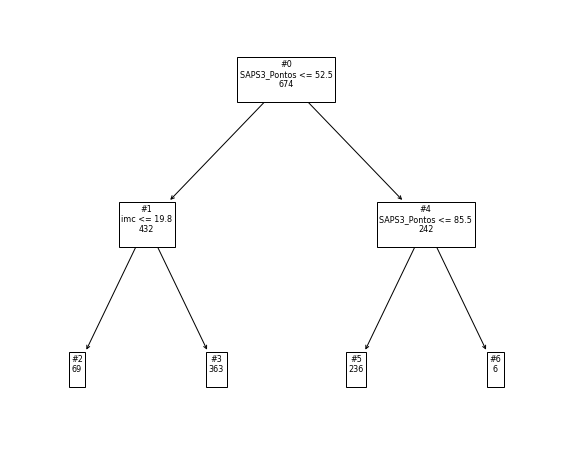

In [74]:
fig = plt.figure(figsize=(10, 8))
plot_survival_tree.plot_tree(lst_st_instances[0],
                              feature_names=lstFeatures,
                              impurity=False,
                              label=True,
                              precision=1,
                              fontsize=8,
                              rotate=False,
                              node_ids=True)

In [60]:
X_train['risk_score'] = risk_score

In [61]:
X_train['node'] = X_train['risk_score'].rank(method = "min").astype(str)

In [62]:
lst_kp = []

for node in X_train.node.unique():
    kp = KaplanMeierFitter()
    node_index = X_train[X_train['node'] == node].index 
    df_study = df[df.index.isin(node_index)]
    print(node)
    kp.fit(df_study['tempo'], event_observed=df_study['delta'])
    lst_kp.append(kp)

1.0
433.0
364.0
669.0


In [63]:
X_train.groupby('node').size()

node
1.0      363
364.0     69
433.0    236
669.0      6
dtype: int64

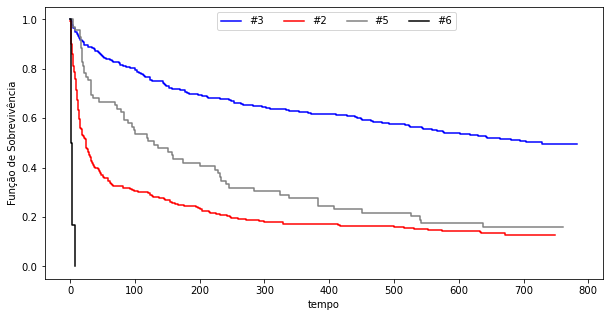

In [75]:
fig = plt.figure(figsize=(10, 5))
colors = ['blue', 'red', 'gray', 'black']
for i in range(len(lst_kp)):
    lst_kp[i].plot_survival_function(legend=False, ci_show=False, color=colors[i])
plt.xlabel("tempo")
plt.ylabel("Função de Sobrevivência")
plt.legend(["#3", "#2", "#5", "#6"], bbox_to_anchor=(0.3, 1.), fancybox=True, ncol=4)

In [84]:
X_train = X_train.drop("node", axis=1)

In [85]:
X_train = X_train.drop("risk_score", axis=1)

[Text(279.0, 380.52, '#0\nSAPS3_Pontos <= 52.5\n674\n'),
 Text(139.5, 271.8, '#1\nimc <= 19.8\n432\n'),
 Text(69.75, 163.07999999999998, '#2\ntipo_quimioterapia_Paliativa <= 0.5\n69\n'),
 Text(34.875, 54.360000000000014, '#3\n65\n'),
 Text(104.625, 54.360000000000014, '#4\n4\n'),
 Text(209.25, 163.07999999999998, '#5\ncapac_func_ecog <= 2.5\n363\n'),
 Text(174.375, 54.360000000000014, '#6\n323\n'),
 Text(244.125, 54.360000000000014, '#7\n40\n'),
 Text(418.5, 271.8, '#8\nSAPS3_Pontos <= 85.5\n242\n'),
 Text(348.75, 163.07999999999998, '#9\nimc <= 25.2\n236\n'),
 Text(313.875, 54.360000000000014, '#10\n163\n'),
 Text(383.625, 54.360000000000014, '#11\n73\n'),
 Text(488.25, 163.07999999999998, '#12\nSAPS3_Pontos <= 88.5\n6\n'),
 Text(453.375, 54.360000000000014, '#13\n3\n'),
 Text(523.125, 54.360000000000014, '#14\n3\n')]

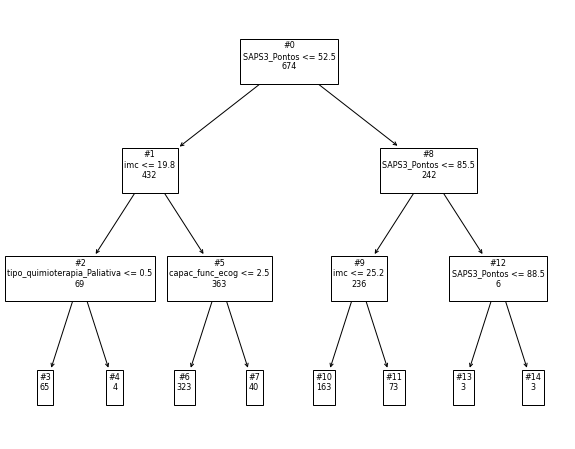

In [86]:
fig = plt.figure(figsize=(10, 8))
plot_survival_tree.plot_tree(lst_st_instances[1],
                              feature_names=lstFeatures,
                              impurity=False,
                              label="none",
                              precision=1,
                              fontsize=8,
                              rotate=False,
                              node_ids=True)

In [87]:
X_train['risk_score'] = lst_st_instances[1].predict(X_train)

In [88]:
X_train['node'] = X_train['risk_score'].rank(method = "min").astype(str)

In [92]:
lst_kp = []

for node in ['1.0', '324.0', '668.0', '672.0']:
    kp = KaplanMeierFitter()
    node_index = X_train[X_train['node'] == node].index 
    df_study = df[df.index.isin(node_index)]
    print(node)
    kp.fit(df_study['tempo'], event_observed=df_study['delta'])
    lst_kp.append(kp)

1.0
324.0
668.0
672.0


In [93]:
X_train.groupby('node').size()

node
1.0      323
324.0     65
389.0     40
429.0     73
502.0      3
505.0    163
668.0      4
672.0      3
dtype: int64

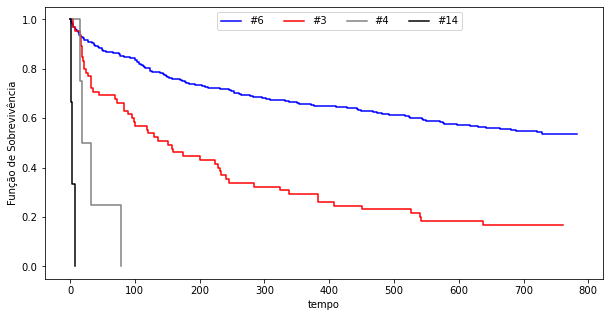

In [95]:
fig = plt.figure(figsize=(10, 5))
colors = ['blue', 'red', 'gray', 'black', 'violet', 'green', 'purple', 'pink']
for i in range(len(lst_kp)):
    lst_kp[i].plot_survival_function(legend=False, ci_show=False, color=colors[i])
plt.xlabel("tempo")
plt.ylabel("Função de Sobrevivência")
plt.legend(["#6", "#3", "#4", "#14"], bbox_to_anchor=(0.3, 1.), fancybox=True, ncol=4)

In [108]:
lst_kp[3].median_survival_time_

3.0

In [96]:
X_train = X_train.drop("node", axis=1)

In [97]:
X_train = X_train.drop("risk_score", axis=1)

In [100]:
X_test = X_test.drop("node", axis=1)

In [101]:
X_test = X_test.drop("risk_score", axis=1)

In [98]:
lst_train_c_index_depth = list(map(lambda instances: instances.score(X_train, y_train), lst_st_instances))

In [102]:
lst_test_c_index_depth = list(map(lambda instances: instances.score(X_test, y_test), lst_st_instances))

In [103]:
results = pd.DataFrame({"profundidade": choices_max_depth, 
                        "c_indice_treino": lst_train_c_index_depth,
                        "c_indice_teste": lst_test_c_index_depth})

(0.5, 1.0)

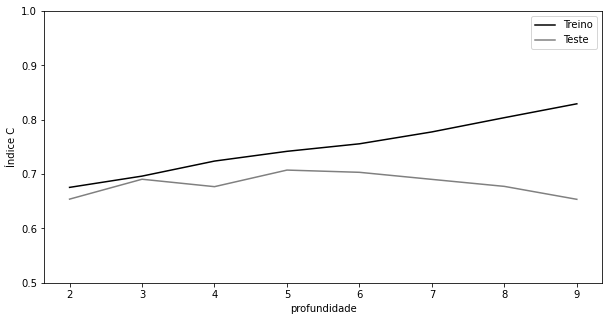

In [106]:
fig = plt.figure(figsize=(10, 5))
sns.lineplot(data=results, x="profundidade", y="c_indice_treino", legend=False, color="black")
sns.lineplot(data=results, x="profundidade", y="c_indice_teste", legend=False, color="gray")
plt.ylabel("Índice C")
plt.legend(["Treino", "Teste"])
plt.ylim(0.5, 1.)

In [109]:
choices_min_samples_leaf = np.arange(5, 51, 1)

In [110]:
lst_st_instances = list(map(lambda min_samples: SurvivalTree(min_samples_leaf=min_samples), 
                            choices_min_samples_leaf))

In [111]:
lst_st_trains = list(map(lambda instances: instances.fit(X_train, y_train), lst_st_instances))

[Text(430.70625, 504.7714285714286, '#0\nSAPS3_Pontos <= 52.5\n674\n'),
 Text(226.6875, 427.11428571428576, '#1\nimc <= 19.8\n432\n'),
 Text(181.35, 349.4571428571429, '#2\n69\n'),
 Text(272.025, 349.4571428571429, '#3\nSAPS3_Pontos <= 43.5\n363\n'),
 Text(181.35, 271.8, '#4\ncapac_func_ecog <= 1.5\n255\n'),
 Text(136.0125, 194.14285714285717, '#5\nimc <= 28.3\n205\n'),
 Text(90.675, 116.48571428571432, '#6\nSAPS3_Pontos <= 34.5\n149\n'),
 Text(45.3375, 38.82857142857142, '#7\n82\n'),
 Text(136.0125, 38.82857142857142, '#8\n67\n'),
 Text(181.35, 116.48571428571432, '#9\n56\n'),
 Text(226.6875, 194.14285714285717, '#10\n50\n'),
 Text(362.7, 271.8, '#11\nQV.0 <= 0.5\n108\n'),
 Text(317.3625, 194.14285714285717, '#12\n51\n'),
 Text(408.03749999999997, 194.14285714285717, '#13\n57\n'),
 Text(634.725, 427.11428571428576, '#14\nimc <= 25.2\n242\n'),
 Text(589.3874999999999, 349.4571428571429, '#15\nsite_primario_digestive tract <= 0.5\n165\n'),
 Text(544.05, 271.8, '#16\nSAPS3_Pontos <= 65.5

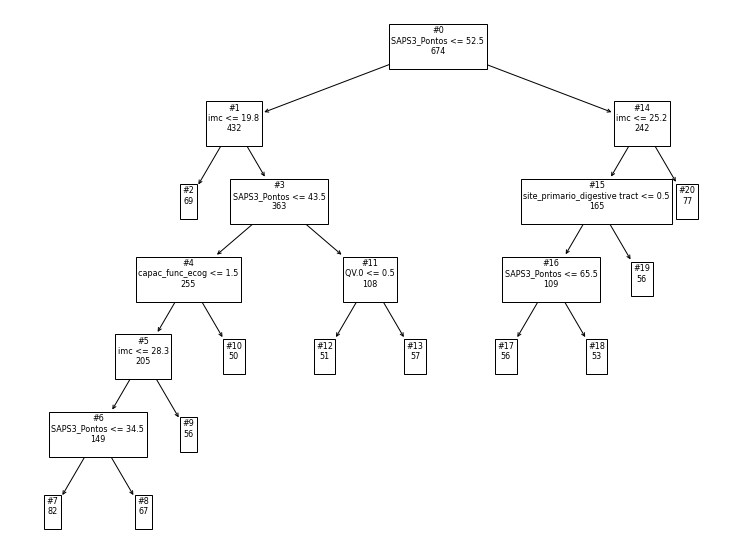

In [113]:
fig = plt.figure(figsize=(13, 10))
plot_survival_tree.plot_tree(lst_st_instances[-1],
                              feature_names=lstFeatures,
                              impurity=False,
                              label="none",
                              precision=1,
                              fontsize=8,
                              rotate=False,
                              node_ids=True)

[Text(382.84999999999997, 513.4, 'SAPS3_Pontos <= 52.5\n674\n'),
 Text(201.5, 453.0, 'imc <= 19.8\n432\n'),
 Text(120.89999999999999, 392.6, 'SAPS3_Pontos <= 41.5\n69\n'),
 Text(80.6, 332.2, '37\n'),
 Text(161.2, 332.2, '32\n'),
 Text(282.09999999999997, 392.6, 'capac_func_ecog <= 2.5\n363\n'),
 Text(241.79999999999998, 332.2, 'SAPS3_Pontos <= 43.5\n323\n'),
 Text(161.2, 271.8, 'QV.0 <= 0.8\n232\n'),
 Text(120.89999999999999, 211.39999999999998, 'imc <= 28.3\n173\n'),
 Text(80.6, 151.0, 'QV.0 <= 0.7\n124\n'),
 Text(40.3, 90.59999999999997, '57\n'),
 Text(120.89999999999999, 90.59999999999997, 'SAPS3_Pontos <= 35.5\n67\n'),
 Text(80.6, 30.199999999999932, '32\n'),
 Text(161.2, 30.199999999999932, '35\n'),
 Text(161.2, 151.0, '49\n'),
 Text(201.5, 211.39999999999998, '59\n'),
 Text(322.4, 271.8, 'imc <= 23.7\n91\n'),
 Text(282.09999999999997, 211.39999999999998, '35\n'),
 Text(362.7, 211.39999999999998, '56\n'),
 Text(322.4, 332.2, '40\n'),
 Text(564.1999999999999, 453.0, 'imc <= 25.2\n2

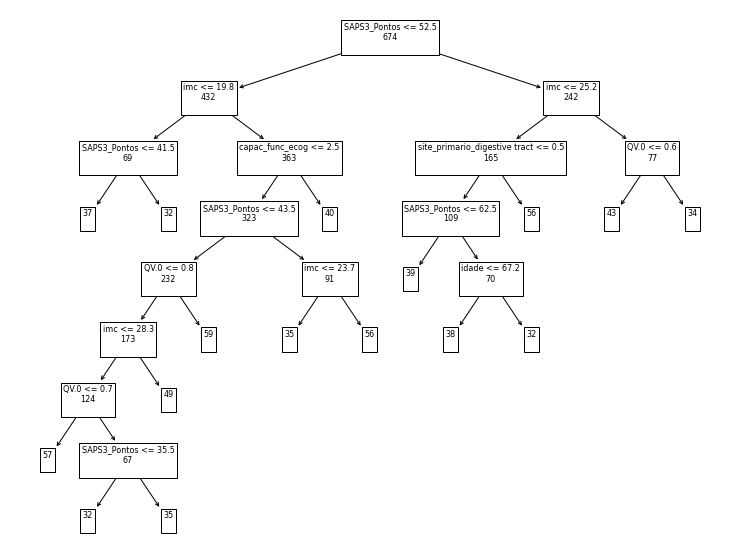

In [41]:
fig = plt.figure(figsize=(13, 10))
plot_survival_tree.plot_tree(lst_st_instances[-20],
                              feature_names=lstFeatures,
                              impurity=False,
                              label="none",
                              precision=1,
                              fontsize=8,
                              rotate=False)

In [114]:
lst_train_c_index_depth = list(map(lambda instances: instances.score(X_train, y_train), lst_st_instances))

In [115]:
lst_test_c_index_depth = list(map(lambda instances: instances.score(X_test, y_test), lst_st_instances))

In [116]:
results = pd.DataFrame({"numero_minimo": choices_min_samples_leaf, 
                        "c_indice_treino": lst_train_c_index_depth,
                        "c_indice_teste": lst_test_c_index_depth})

(0.5, 1.0)

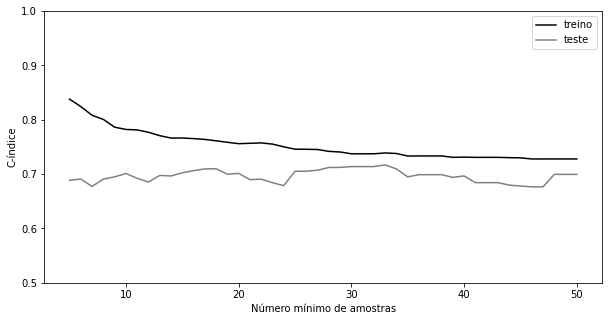

In [117]:
fig = plt.figure(figsize=(10, 5))
sns.lineplot(data=results, x="numero_minimo", y="c_indice_treino", legend=False, color="black")
sns.lineplot(data=results, x="numero_minimo", y="c_indice_teste", legend=False, color="gray")
plt.ylabel("C-índice")
plt.xlabel("Número mínimo de amostras")
plt.legend(["treino", "teste"])
plt.ylim(0.5, 1.)

In [118]:
choices_hyperparameters = list(product(choices_min_samples_leaf, choices_max_depth))

In [119]:
lst_st_instances = list(map(lambda x: SurvivalTree(max_depth=x[1], min_samples_leaf=x[0]), 
                            choices_hyperparameters))

In [120]:
lst_st_trains = list(map(lambda instances: instances.fit(X_train, y_train), lst_st_instances))

In [121]:
lst_train_c_index = list(map(lambda instances: instances.score(X_train, y_train), lst_st_instances))

In [122]:
lst_test_c_index = list(map(lambda instances: instances.score(X_test, y_test), lst_st_instances))

In [123]:
results = pd.DataFrame({"numero_minimo": [i[0] for i in choices_hyperparameters],
                        "profundidade": [i[1] for i in choices_hyperparameters],
                        "c_indice_treino": lst_train_c_index,
                        "c_indice_teste": lst_test_c_index})

In [124]:
results['c_indice_delta'] = results['c_indice_treino'] - results['c_indice_teste']

In [125]:
results_matrix = results.pivot(index="profundidade", columns="numero_minimo", values="c_indice_delta")

In [126]:
results_matrix_test = results.pivot(index="profundidade", columns="numero_minimo", values="c_indice_teste")

In [127]:
results_matrix_refine = results_matrix.loc[[2, 3, 4, 5, 6, 7, 8], [5, 10, 15, 20, 25, 30, 35, 40]]

In [128]:
results_matrix_test_refine = results_matrix_test.loc[[2, 3, 4, 5, 6, 7, 8], [5, 10, 15, 20, 25, 30, 35, 40]]

Text(0.5, 51.0, 'número mínimos de amostras nas folhas')

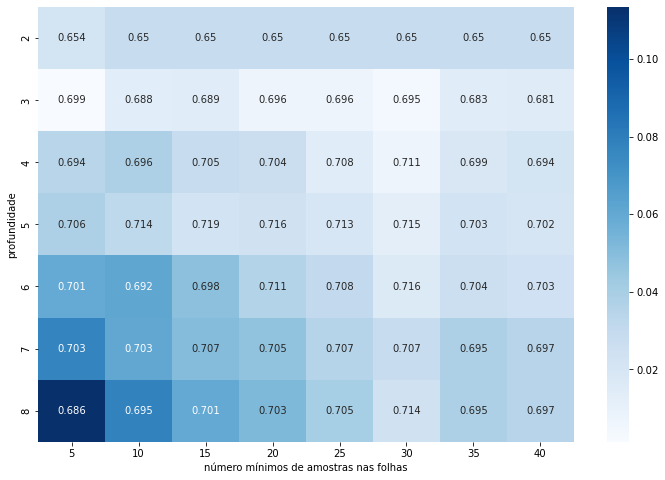

In [129]:
fig = plt.figure(figsize=(12, 8))
sns.heatmap(results_matrix_refine, annot=results_matrix_test_refine.values, fmt='.3g', cmap="Blues")
plt.xlabel("número mínimos de amostras nas folhas")

- Realizar uma seção com esses gráficos. Fazer uma discussão do mapa de calor com as escolhas da validação cruzada. 